In [62]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

from models.convolutional_vae_v2 import ConvolutionalVAEV2 
from models.convolutional_vae_v2 import preprocess_grid as preprocess_vaev2, postprocess_grid as postprocess_vaev2
from models.convolutional_vqvae import ConvolutionalVQVAE
from models.convolutional_vqvae import preprocess_grid as preprocess_vq, postprocess_grid as postprocess_vq
from models.fully_connected_vae import FullyConnectedVAE
from models.ppca_pipeline import preprocess_grid as preprocess_ppca_into_vae, postprocess_grid as postprocess_ppca_into_vae
from models.ppca_pipeline import get_compression_functions as get_ppca_into_vae_compresison_functions
from models.vq_pipeline import preprocess_grid as preprocess_vq_into_vae, postprocess_grid as postprocess_vq_into_vae
from models.vq_pipeline import get_compression_functions as get_vq_into_vae_compression_functions
from models.latent_solver import LatentSolver

from scipy.special import softmax
from sklearn.metrics.pairwise import cosine_similarity

from models.pipeline import Pipeline
from utils.view import draw_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
model = ConvolutionalVAEV2(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=128,
    feature_dim=[8, 8]
).to(device)

model_name="conv_vaev2_128_b1"
checkpoint = torch.load(f'../../checkpoints/{model_name}.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vaev2,
    postprocess_fn=postprocess_vaev2,
)
model_type = "vae"

In [63]:
model = ConvolutionalVQVAE(
    in_channels=10, 
    starting_filters=64, 
    num_embeddings=256,
    embedding_dim=64,
    commitment_cost=0.25
).to(device)

model_name = "conv_vqvae_6x6x64_b2"
checkpoint = torch.load(f'../../checkpoints/{model_name}.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vq,
    postprocess_fn=postprocess_vq,
)
model_type = "vq"

In [ ]:
input_dim = 6*6*64
model = FullyConnectedVAE(
    input_dim=input_dim,
    hidden_dim=1024,
    latent_dim=64
).to(device)

model_name = "vq_vae_64_b1"
checkpoint = torch.load(f'../../checkpoints/{model_name}.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

compress_fn, decompress_fn = get_vq_into_vae_compression_functions('../../checkpoints/conv_vqvae_6x6x64_b2.pt')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vq_into_vae,
    postprocess_fn=postprocess_vq_into_vae,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)
model_type = "vae"

In [ ]:
n_components = 128

input_dim = n_components
model = FullyConnectedVAE(
    input_dim=input_dim,
    hidden_dim=1024,
    latent_dim=64
).to(device)

model_name = "ppca128_vae_64_b5"
checkpoint = torch.load(f'../../checkpoints/{model_name}.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

compress_fn, decompress_fn = get_ppca_into_vae_compresison_functions(f'../../checkpoints/ppca_{n_components}.pkl')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_ppca_into_vae,
    postprocess_fn=postprocess_ppca_into_vae,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)
model_type = "vae"

In [ ]:
def grid_to_latent(pipeline: Pipeline, grids_batch, model_type="vq"):
    if model_type == 'vq':
        z = pipeline.encode(grids_batch.to(device))
    else:
        z, _ = pipeline.encode(grids_batch.to(device))

    z_size = z.size()[1:]
    z_flat = z.view(z.size(0), -1)

    return z_flat, z_size

def latent_to_grid(pipeline: Pipeline, z, expected_outputs, model_type="vq"):
    if model_type == 'vq':
        z_quantized, _, _ = pipeline.model.quantize(z.to(device))
        decoded = pipeline.decode(z_quantized)
    else:
        decoded = pipeline.decode(z.to(device))

    expected_outputs = [expected_outputs]
    decoded = decoded.cpu()

    postprocessed = [
        pipeline.decompress_and_postprocess(decoded[i], expected_outputs[i])
        for i in range(decoded.size(0))
    ]

    return postprocessed

In [64]:
from utils.load_data import get_grids

training_data, validation_data  = get_grids(filepath="../../data/training")

In [65]:
import torch.nn as nn

training_grid_pairs = [pair for task in training_data.values() for pairs in task.values() for pair in pairs]
validation_grid_pairs = [pair for task in validation_data.values() for pairs in task.values() for pair in pairs]

batch_size = 4
train_loader = pipeline.create_data_loader(training_grid_pairs, batch_size=batch_size, shuffle=True)
val_loader = pipeline.create_data_loader(validation_grid_pairs, batch_size=batch_size, shuffle=False)

first_batch = next(iter(train_loader))

_, z_size = grid_to_latent(pipeline, first_batch[0], model_type)

latent_dim = torch.prod(torch.tensor(z_size)).item()
hidden_dim = 512

solver = LatentSolver(latent_dim=latent_dim, hidden_dim=hidden_dim)

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(solver.parameters(), lr=5e-5, weight_decay=1e-3)

In [66]:
max_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

# ----- Training Loop -----
for epoch in range(1, max_epochs + 1):
    solver.train()
    total_train_loss = 0.0

    for input, output in train_loader:
        z_in_batch, _ = grid_to_latent(pipeline, input, model_type)
        z_out_batch, _ = grid_to_latent(pipeline, output, model_type)

        optimizer.zero_grad()
        predicted_z_out = solver(z_in_batch)
        loss = loss_fn(predicted_z_out, z_out_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * z_in_batch.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)

    # Validation
    solver.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for input, output in val_loader:
            z_in_batch, _ = grid_to_latent(pipeline, input, model_type)
            z_out_batch, _ = grid_to_latent(pipeline, output, model_type)

            predicted_z_out = solver(z_in_batch)
            loss = loss_fn(predicted_z_out, z_out_batch)
            total_val_loss += loss.item() * z_in_batch.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(solver.state_dict(), f"../../checkpoints/solver_{latent_dim}_{hidden_dim}_{model_name}.pt")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping.")
            break

Epoch 1 | Train Loss: 10.916088 | Val Loss: 9.772008
Epoch 2 | Train Loss: 10.011203 | Val Loss: 9.722747
Epoch 3 | Train Loss: 9.906154 | Val Loss: 9.709014
Epoch 4 | Train Loss: 9.785807 | Val Loss: 9.662054
Epoch 5 | Train Loss: 9.640726 | Val Loss: 9.642785
Epoch 6 | Train Loss: 9.514545 | Val Loss: 9.636604
Epoch 7 | Train Loss: 9.353676 | Val Loss: 9.606200
Epoch 8 | Train Loss: 9.230505 | Val Loss: 9.588086
Epoch 9 | Train Loss: 9.102673 | Val Loss: 9.648288
Epoch 10 | Train Loss: 8.996850 | Val Loss: 9.602888
Epoch 11 | Train Loss: 8.887602 | Val Loss: 9.593751
Epoch 12 | Train Loss: 8.786366 | Val Loss: 9.570631
Epoch 13 | Train Loss: 8.683522 | Val Loss: 9.607756
Epoch 14 | Train Loss: 8.588938 | Val Loss: 9.624038
Epoch 15 | Train Loss: 8.509094 | Val Loss: 9.608425
Epoch 16 | Train Loss: 8.402865 | Val Loss: 9.642032
Epoch 17 | Train Loss: 8.319576 | Val Loss: 9.659708
Early stopping.


In [67]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

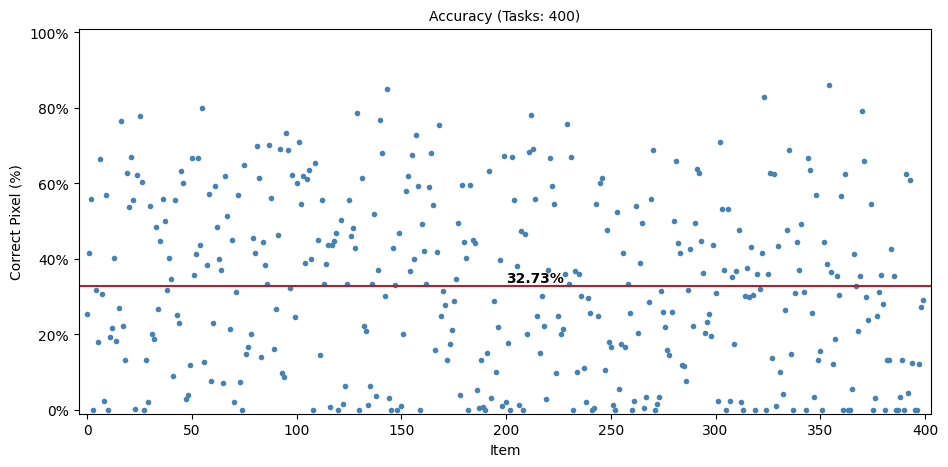

Number of 100% Correct: 0
Number of 90%+ Correct: 0
Number of 80%+ Correct: 4
Number of 70%+ Correct: 18


In [73]:
solved_puzzles = []

def compute_accuracy(original, decoded):
        correct = (original == decoded)
        accuracy = correct.mean().item()
        is_perfect = accuracy == 1.0
        return accuracy, is_perfect

accuracies = []    

# counter = 0
for puzzle_id, task in data.items():
    # if counter >= 10:
    #      break
    # counter +=1
    input, output = task['test'][0]

    input = pipeline.preprocess_and_compress(input)
    z_input, z_size = grid_to_latent(pipeline, input.unsqueeze(0), model_type)
    
    z_pred = solver(z_input)
    z_pred = z_pred.view(*z_size).unsqueeze(0)
    pred = latent_to_grid(pipeline, z_pred, output, model_type)[0]

    original = output
    acc, perfect = compute_accuracy(pred, original)
    accuracies.append(acc)

    if perfect:
        solved_puzzles.append(puzzle_id)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        draw_grid(axes[0], pred, f"Puzzle {puzzle_id} Predicted output")
        draw_grid(axes[1], original, f"Puzzle {puzzle_id} Original output")

mean = np.mean(accuracies)

ig, ax = plt.subplots(figsize=(11,5))
plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
plt.axhline(mean, xmax = len(accuracies), color='firebrick')
plt.title(f'Accuracy (Tasks: {len(accuracies)})', size='medium')
plt.xlabel('Item')
plt.ylabel('Correct Pixel (%)')
plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
plt.ylim(-0.01, 1.01)
plt.margins(x=0.01)
plt.show()

print(f'Number of 100% Correct: {accuracies.count(1)}')
print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')
    